In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

from gptchem.data import get_hea_phase_data
from gptchem.evaluator import evaluate_classification
from gptchem.formatter import ClassificationFormatter
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])
%matplotlib inline

## Get the dummy metrics

In [3]:
data = get_hea_phase_data()

In [4]:
estimators = ["uniform", "stratified", "most_frequent"]
results = []
train_sizes = [10, 20, 50, 100, 200, 500]
for i in range(10):
    for estimator in estimators:
        for train_size in train_sizes:
            train, test = train_test_split(
                data,
                train_size=train_size,
                test_size=250,
                stratify=data["phase_encoded"],
                random_state=i,
            )
            classifier = DummyClassifier(strategy=estimator)
            classifier.fit(train["Alloy"], train["phase_encoded"])
            predictions = classifier.predict(test["Alloy"])
            res = evaluate_classification(test["phase_encoded"], predictions)
            res["train_size"] = train_size
            res["estimator"] = estimator
            results.append(res)

In [5]:
dummy_results = pd.DataFrame(results)

In [6]:
dummy_grouped = (
    dummy_results[["train_size", "estimator", "accuracy", "f1_macro", "f1_micro", "kappa"]]
    .groupby(["estimator", "train_size"])
    .agg(["mean", "std", sem])
)

In [7]:
dummy_grouped

accuracy                      f1_macro            \
                             mean       std       sem      mean       std   
estimator     train_size                                                    
most_frequent 10           0.5000  0.000000  0.000000  0.166667  0.000000   
              20           0.5000  0.000000  0.000000  0.166667  0.000000   
              50           0.5000  0.000000  0.000000  0.166667  0.000000   
              100          0.5000  0.000000  0.000000  0.166667  0.000000   
              200          0.5000  0.000000  0.000000  0.166667  0.000000   
              500          0.5000  0.000000  0.000000  0.166667  0.000000   
stratified    10           0.3500  0.022410  0.007087  0.258359  0.029265   
              20           0.3348  0.020400  0.006451  0.250826  0.018823   
              50           0.3340  0.027793  0.008789  0.244260  0.025336   
              100          0.3452  0.025302  0.008001  0.266049  0.019206   
              200          0.3432  0.021065  0.006661  0.250952  0.023295   
              500          0.3548  0.022315  0.007057  0.260158  0.027552   
uniform       10           0.2460  0.020155  0.006374  0.226781  0.020868   
              20           0.2544  0.026005  0.008224  0.234758  0.023616   
              50           0.2528  0.026114  0.008258  0.232377  0.022271   
              100          0.2632  0.030742  0.009721  0.242020  0.030767   
              200          0.2492  0.032169  0.010173  0.229972  0.028858   
              500          0.2276  0.027289  0.008630  0.209730  0.023583   

                                       f1_micro                         kappa  \
                                   sem     mean       std       sem      mean   
estimator     train_size                                                        
most_frequent 10          9.251859e-18   0.5000  0.000000  0.000000  0.000000   
              20          9.251859e-18   0.5000  0.000000  0.000000  0.000000   
              50          9.251859e-18   0.5000  0.000000  0.000000  0.000000   
              100         9.251859e-18   0.5000  0.000000  0.000000  0.000000   
              200         9.251859e-18   0.5000  0.000000  0.000000  0.000000   
              500         9.251859e-18   0.5000  0.000000  0.000000  0.000000   
stratified    10          9.254280e-03   0.3500  0.022410  0.007087  0.014090   
              20          5.952399e-03   0.3348  0.020400  0.006451  0.004959   
              50          8.011827e-03   0.3340  0.027793  0.008789 -0.004642   
              100         6.073592e-03   0.3452  0.025302  0.008001  0.017667   
              200         7.366671e-03   0.3432  0.021065  0.006661  0.008663   
              500         8.712596e-03   0.3548  0.022315  0.007057  0.020697   
uniform       10          6.598971e-03   0.2460  0.020155  0.006374 -0.007131   
              20          7.468079e-03   0.2544  0.026005  0.008224  0.004861   
              50          7.042672e-03   0.2528  0.026114  0.008258 -0.001963   
              100         9.729229e-03   0.2632  0.030742  0.009721  0.014627   
              200         9.125631e-03   0.2492  0.032169  0.010173 -0.000500   
              500         7.457583e-03   0.2276  0.027289  0.008630 -0.031444   

                                              
                               std       sem  
estimator     train_size                      
most_frequent 10          0.000000  0.000000  
              20          0.000000  0.000000  
              50          0.000000  0.000000  
              100         0.000000  0.000000  
              200         0.000000  0.000000  
              500         0.000000  0.000000  
stratified    10          0.034718  0.010979  
              20          0.030862  0.009760  
              50          0.040096  0.012679  
              100         0.027746  0.008774  
              200         0.034407  0.010880  
              500         0.036100  0.011416  


## Load the results

In [8]:
all_out = glob("out/**/*.pkl")

In [9]:
all_out = [load_pickle(p) for p in all_out]

In [10]:
extracted_res = []

for out in all_out:
    res = {
        "base_model": out["base_model"],
        "train_size": out["train_size"],
        "test_size": out["test_size"],
        "n_epochs": out["n_epochs"],
        "learning_rate_multiplier": out["learning_rate_multiplier"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    extracted_res.append(res)

In [11]:
extracted_res = pd.DataFrame(extracted_res)

In [12]:
extracted_res_grouped = extracted_res.groupby(["train_size"]).agg(["mean", "std", sem])

In [13]:
extracted_res_grouped

test_size           n_epochs           learning_rate_multiplier  \
                mean  std  sem     mean  std  sem                     mean   
train_size                                                                   
10             250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
20             250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
50             250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
100            250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
200            250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
500            250.0  0.0  0.0      8.0  0.0  0.0                     0.02   

                              frac_valid  ...  accuracy  f1_macro            \
            std           sem       mean  ...       sem      mean       std   
train_size                                ...                                 
10          0.0  1.156482e-18     1.0000  ...  0.014383  0.330901  0.064133   
20          0.0  1.156482e-18     1.0000  ...  0.013546  0.407747  0.043086   
50          0.0  1.156482e-18     1.0000  ...  0.012036  0.525752  0.055664   
100         0.0  1.156482e-18     0.9996  ...  0.010885  0.627855  0.055675   
200         0.0  1.156482e-18     1.0000  ...  0.009078  0.704810  0.042107   
500         0.0  1.156482e-18     1.0000  ...  0.010567  0.792268  0.049481   

                      f1_micro                         kappa            \
                 sem      mean       std       sem      mean       std   
train_size                                                               
10          0.020281  0.603200  0.045482  0.014383  0.356974  0.135828   
20          0.013625  0.634800  0.042835  0.013546  0.444549  0.051856   
50          0.017602  0.688400  0.038062  0.012036  0.527397  0.052787   
100         0.017606  0.756694  0.034420  0.010885  0.627917  0.052817   
200         0.013315  0.800800  0.028708  0.009078  0.697422  0.043087   
500         0.015647  0.857200  0.033416  0.010567  0.784465  0.049877   

                      
                 sem  
train_size            
10          0.042952  
20          0.016398  
50          0.016693  
100         0.016702  
200         0.013625  
500         0.015772  

[6 rows x 24 columns]

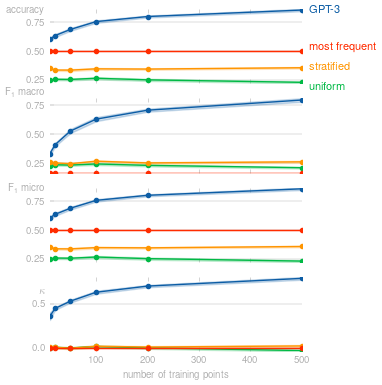

In [14]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(
        4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex=True
    )

    # accuracy
    ax[0].plot(
        extracted_res_grouped.index,
        extracted_res_grouped["accuracy"]["mean"],
        label="GPT-3",
        marker="o",
    )
    ax[0].fill_between(
        extracted_res_grouped.index,
        extracted_res_grouped["accuracy"]["mean"] - extracted_res_grouped["accuracy"]["sem"],
        extracted_res_grouped["accuracy"]["mean"] + extracted_res_grouped["accuracy"]["sem"],
        alpha=0.2,
        # label='GPT-3',
        color="C0",
    )

    # add the dummy models
    for i, estimator in enumerate(estimators):
        ax[0].plot(
            dummy_grouped.loc[estimator, :]["accuracy"]["mean"].index,
            dummy_grouped.loc[estimator, :]["accuracy"]["mean"],
            label=estimator.replace("_", " "),
            marker="o",
            color=f"C{i+1}",
        )
        ax[0].fill_between(
            dummy_grouped.loc[estimator, :]["accuracy"]["mean"].index,
            dummy_grouped.loc[estimator, :]["accuracy"]["mean"]
            - dummy_grouped.loc[estimator, :]["accuracy"]["sem"],
            dummy_grouped.loc[estimator, :]["accuracy"]["mean"]
            + dummy_grouped.loc[estimator, :]["accuracy"]["sem"],
            alpha=0.2,
            color=f"C{i+1}",
        )

    # f1 macro
    ax[1].plot(
        extracted_res_grouped.index,
        extracted_res_grouped["f1_macro"]["mean"],
        label="GPT-3",
        marker="o",
    )
    ax[1].fill_between(
        extracted_res_grouped.index,
        extracted_res_grouped["f1_macro"]["mean"] - extracted_res_grouped["f1_macro"]["sem"],
        extracted_res_grouped["f1_macro"]["mean"] + extracted_res_grouped["f1_macro"]["sem"],
        alpha=0.2,
        color="C0",
    )

    # add the dummy models
    for i, estimator in enumerate(estimators):
        ax[1].plot(
            dummy_grouped.loc[estimator, :]["f1_macro"]["mean"].index,
            dummy_grouped.loc[estimator, :]["f1_macro"]["mean"],
            label=estimator.replace("_", " "),
            marker="o",
            color=f"C{i+1}",
        )
        ax[1].fill_between(
            dummy_grouped.loc[estimator, :]["f1_macro"]["mean"].index,
            dummy_grouped.loc[estimator, :]["f1_macro"]["mean"]
            - dummy_grouped.loc[estimator, :]["f1_macro"]["sem"],
            dummy_grouped.loc[estimator, :]["f1_macro"]["mean"]
            + dummy_grouped.loc[estimator, :]["f1_macro"]["sem"],
            alpha=0.2,
            color=f"C{i+1}",
        )

    # f1 micro

    ax[2].plot(
        extracted_res_grouped.index,
        extracted_res_grouped["f1_micro"]["mean"],
        label="GPT-3",
        marker="o",
    )
    ax[2].fill_between(
        extracted_res_grouped.index,
        extracted_res_grouped["f1_micro"]["mean"] - extracted_res_grouped["f1_micro"]["sem"],
        extracted_res_grouped["f1_micro"]["mean"] + extracted_res_grouped["f1_micro"]["sem"],
        alpha=0.2,
        color="C0",
    )

    # add the dummy models
    for i, estimator in enumerate(estimators):
        ax[2].plot(
            dummy_grouped.loc[estimator, :]["f1_micro"]["mean"].index,
            dummy_grouped.loc[estimator, :]["f1_micro"]["mean"],
            label=estimator.replace("_", " "),
            marker="o",
            color=f"C{i+1}",
        )
        ax[2].fill_between(
            dummy_grouped.loc[estimator, :]["f1_micro"]["mean"].index,
            dummy_grouped.loc[estimator, :]["f1_micro"]["mean"]
            - dummy_grouped.loc[estimator, :]["f1_micro"]["sem"],
            dummy_grouped.loc[estimator, :]["f1_micro"]["mean"]
            + dummy_grouped.loc[estimator, :]["f1_micro"]["sem"],
            alpha=0.2,
            color=f"C{i+1}",
        )

    # kappa
    ax[3].plot(
        extracted_res_grouped.index,
        extracted_res_grouped["kappa"]["mean"],
        label="GPT-3",
        marker="o",
    )
    ax[3].fill_between(
        extracted_res_grouped.index,
        extracted_res_grouped["kappa"]["mean"] - extracted_res_grouped["kappa"]["sem"],
        extracted_res_grouped["kappa"]["mean"] + extracted_res_grouped["kappa"]["sem"],
        alpha=0.2,
        color="C0",
    )

    # add the dummy models
    for i, estimator in enumerate(estimators):
        ax[3].plot(
            dummy_grouped.loc[estimator, :]["kappa"]["mean"].index,
            dummy_grouped.loc[estimator, :]["kappa"]["mean"],
            label=estimator.replace("_", " "),
            marker="o",
            color=f"C{i+1}",
        )
        ax[3].fill_between(
            dummy_grouped.loc[estimator, :]["kappa"]["mean"].index,
            dummy_grouped.loc[estimator, :]["kappa"]["mean"]
            - dummy_grouped.loc[estimator, :]["kappa"]["sem"],
            dummy_grouped.loc[estimator, :]["kappa"]["mean"]
            + dummy_grouped.loc[estimator, :]["kappa"]["sem"],
            alpha=0.2,
            color=f"C{i+1}",
        )

    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])
    ax[-1].set_xlabel("number of training points", labelpad=4)
    matplotx.line_labels(ax=ax[0], fontsize=8)

    fig.savefig("hea_phase_classifier.pdf", bbox_inches="tight")

In [15]:
dummy_grouped

accuracy                      f1_macro            \
                             mean       std       sem      mean       std   
estimator     train_size                                                    
most_frequent 10           0.5000  0.000000  0.000000  0.166667  0.000000   
              20           0.5000  0.000000  0.000000  0.166667  0.000000   
              50           0.5000  0.000000  0.000000  0.166667  0.000000   
              100          0.5000  0.000000  0.000000  0.166667  0.000000   
              200          0.5000  0.000000  0.000000  0.166667  0.000000   
              500          0.5000  0.000000  0.000000  0.166667  0.000000   
stratified    10           0.3500  0.022410  0.007087  0.258359  0.029265   
              20           0.3348  0.020400  0.006451  0.250826  0.018823   
              50           0.3340  0.027793  0.008789  0.244260  0.025336   
              100          0.3452  0.025302  0.008001  0.266049  0.019206   
              200          0.3432  0.021065  0.006661  0.250952  0.023295   
              500          0.3548  0.022315  0.007057  0.260158  0.027552   
uniform       10           0.2460  0.020155  0.006374  0.226781  0.020868   
              20           0.2544  0.026005  0.008224  0.234758  0.023616   
              50           0.2528  0.026114  0.008258  0.232377  0.022271   
              100          0.2632  0.030742  0.009721  0.242020  0.030767   
              200          0.2492  0.032169  0.010173  0.229972  0.028858   
              500          0.2276  0.027289  0.008630  0.209730  0.023583   

                                       f1_micro                         kappa  \
                                   sem     mean       std       sem      mean   
estimator     train_size                                                        
most_frequent 10          9.251859e-18   0.5000  0.000000  0.000000  0.000000   
              20          9.251859e-18   0.5000  0.000000  0.000000  0.000000   
              50          9.251859e-18   0.5000  0.000000  0.000000  0.000000   
              100         9.251859e-18   0.5000  0.000000  0.000000  0.000000   
              200         9.251859e-18   0.5000  0.000000  0.000000  0.000000   
              500         9.251859e-18   0.5000  0.000000  0.000000  0.000000   
stratified    10          9.254280e-03   0.3500  0.022410  0.007087  0.014090   
              20          5.952399e-03   0.3348  0.020400  0.006451  0.004959   
              50          8.011827e-03   0.3340  0.027793  0.008789 -0.004642   
              100         6.073592e-03   0.3452  0.025302  0.008001  0.017667   
              200         7.366671e-03   0.3432  0.021065  0.006661  0.008663   
              500         8.712596e-03   0.3548  0.022315  0.007057  0.020697   
uniform       10          6.598971e-03   0.2460  0.020155  0.006374 -0.007131   
              20          7.468079e-03   0.2544  0.026005  0.008224  0.004861   
              50          7.042672e-03   0.2528  0.026114  0.008258 -0.001963   
              100         9.729229e-03   0.2632  0.030742  0.009721  0.014627   
              200         9.125631e-03   0.2492  0.032169  0.010173 -0.000500   
              500         7.457583e-03   0.2276  0.027289  0.008630 -0.031444   

                                              
                               std       sem  
estimator     train_size                      
most_frequent 10          0.000000  0.000000  
              20          0.000000  0.000000  
              50          0.000000  0.000000  
              100         0.000000  0.000000  
              200         0.000000  0.000000  
              500         0.000000  0.000000  
stratified    10          0.034718  0.010979  
              20          0.030862  0.009760  
              50          0.040096  0.012679  
              100         0.027746  0.008774  
              200         0.034407  0.010880  
              500         0.036100  0.011416  


In [16]:
dummy_grouped.loc["most_frequent"]

accuracy            f1_macro                    f1_micro            \
               mean  std  sem      mean  std           sem     mean  std  sem   
train_size                                                                      
10              0.5  0.0  0.0  0.166667  0.0  9.251859e-18      0.5  0.0  0.0   
20              0.5  0.0  0.0  0.166667  0.0  9.251859e-18      0.5  0.0  0.0   
50              0.5  0.0  0.0  0.166667  0.0  9.251859e-18      0.5  0.0  0.0   
100             0.5  0.0  0.0  0.166667  0.0  9.251859e-18      0.5  0.0  0.0   
200             0.5  0.0  0.0  0.166667  0.0  9.251859e-18      0.5  0.0  0.0   
500             0.5  0.0  0.0  0.166667  0.0  9.251859e-18      0.5  0.0  0.0   

           kappa            
            mean  std  sem  
train_size                  
10           0.0  0.0  0.0  
20           0.0  0.0  0.0  
50           0.0  0.0  0.0  
100          0.0  0.0  0.0  
200          0.0  0.0  0.0  
500          0.0  0.0  0.0